#### 1) Prepare environment.

In [1]:
import io
import os
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_absolute_error
from sklearn import ensemble
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn import preprocessing
from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()
print('Authenticated')

Authenticated


#### 2) Connect to GCP and create master table from DB.

In [2]:
project_id = 'capstone2020-283620'
client = bigquery.Client(project=project_id)

theMaster = client.query('''
SELECT
  master.Sum_nombre_incidents Target,
  master.date_range Date,
  master.firestation Station,
  master.shift_key as Shift,
  master.year_key as Year,
  master.month_key as Month,
  master.day_key as Day,
  socio.Sum_age_0_14,
  socio.Sum_age_15_64,
  socio.Sum_age_65,
  socio.Sum_Income_10k,
  socio.Sum_Income_20k,
  socio.Sum_Income_30k,
  socio.Sum_Income_40k,
  socio.Sum_Income_50k,
  socio.Sum_Income_60k,
  socio.Sum_Income_70k,
  socio.Sum_Income_80k,
  socio.Sum_Income_90k,
  socio.Sum_Income_100k,
  socio.Sum_Pop_total,
  CASE WHEN house.COOP_sum IS NOT NULL THEN house.COOP_sum ELSE 0 END AS COOP_sum,
  CASE WHEN house.HLM_sum  IS NOT NULL THEN house.HLM_sum  ELSE 0 END AS HLM_sum,
  CASE WHEN house.OBNL_sum IS NOT NULL THEN house.OBNL_sum ELSE 0 END AS OBNL_sum,
  CASE WHEN house.OMHM_sum IS NOT NULL THEN house.OMHM_sum ELSE 0 END AS OMHM_sum,
  CASE WHEN house.SHDM_sum IS NOT NULL THEN house.SHDM_sum ELSE 0 END AS SHDM_sum,
  CASE WHEN holiday.Holiday IS NOT NULL THEN holiday.Holiday ELSE 0 END AS Holiday,
  weather.Temp_DC_Mean,
  weather.Humid_percent_Mean,
  weather.Win_Dir_Mean,
  weather.Wind_Speed_Mean,
  weather.Stn_Press_Mean,
  weather.Temp_DC_Max,
  weather.Humid_percent_Max,
  weather.Win_Dir_Max,
  weather.Wind_Speed_Max,
  weather.Stn_Press_Max,
  weather.Temp_DC_Min,
  weather.Humid_percent_Min,
  weather.Win_Dir_Min,
  weather.Wind_Speed_Min,
  weather.Stn_Press_Min,
  #habs.Mtl_win,
  CASE WHEN habs.Mtl_played IS NOT NULL THEN habs.Mtl_played ELSE 0 END AS Mtl_played,
  CASE WHEN moon.Full_moon  IS NOT NULL THEN moon.Full_moon  ELSE 0 END AS Full_moon
FROM `capstone2020-283620.capstone2020.sim_incidents` master 

# Joining soci-demo table
LEFT JOIN `capstone2020-283620.capstone2020.detailed_socio_profiles` socio
ON master.firestation=socio.NO_CAS_ADM

# Joining social-housing table
LEFT JOIN `capstone2020-283620.capstone2020.social_housing` house
ON master.firestation=house.Station

# Joining holiday_qc table
LEFT JOIN `capstone2020-283620.capstone2020.holiday` holiday
ON master.date_range=holiday.Date

# Weather
LEFT JOIN `capstone2020-283620.capstone2020.weather` weather
ON master.date_range=weather.Date AND master.shift_key=weather.Shift

# Habs schedule
LEFT JOIN `capstone2020-283620.capstone2020.ch_games_fin` habs
ON master.date_range=habs.date AND master.shift_key=habs.Period

# Moon Cycles
LEFT JOIN `capstone2020-283620.capstone2020.moon_cycles` moon
ON master.date_range = moon.date  AND master.shift_key=moon.Period

WHERE master.date_range<='2020-06-01' and master.firestation not in (2,79) # Garbage fire stations.

''').to_dataframe()

In [3]:
master = theMaster.drop(theMaster[(theMaster['Station'] == 32) & (theMaster['Year'] <= 2014)].index)
master = master.drop(theMaster[(theMaster['Station'] == 59) & (theMaster['Year'] <= 2014)].index)

In [4]:
mean = master[['Station','Target']].groupby(['Station']).mean()
std  = master[['Station','Target']].groupby(['Station']).std()
mean = mean.rename(columns={'Target': 'Z_mean'})
std  = std.rename(columns={'Target': 'Z_std'})
total = mean.join(std)
total = total.reset_index()
master = pd.merge(master, total,  how='left', left_on=['Station'], right_on = ['Station'])
master['Target_Z'] = (master['Target'] - master['Z_mean']) / master['Z_std']

In [5]:
# 1 ecart-type pour definir low ou high...
master['Target_Class'] = master['Target'].apply(lambda x: 1 if x <= 1 else 2 if x <= 3  else 3)

#### 3) Cleaning of master table and create features.

In [6]:
# Transformation des informations demos en pourcentage.
col_to_prep = ['Sum_age_0_14', 'Sum_age_15_64', 'Sum_age_65', 'Sum_Income_10k', 'Sum_Income_20k', 'Sum_Income_30k', 
               'Sum_Income_40k', 'Sum_Income_50k', 'Sum_Income_60k', 'Sum_Income_70k', 'Sum_Income_80k', 'Sum_Income_90k', 
               'Sum_Income_100k']
col_to_fin  = ['Age_0_14', 'Age_15_64', 'Age_65', 'Income_10k', 'Income_20k', 'Income_30k', 
               'Income_40k', 'Income_50k', 'Income_60k', 'Income_70k', 'Income_80k', 'Income_90k', 
               'Income_100k']

for prep, fin in zip(col_to_prep, col_to_fin):
  master[fin] = master[prep]/master['Sum_Pop_total']

# On retravaille un peu le format de dates
master['DateFMT'] = pd.to_datetime(master['Date'])
master = master.drop('Date', axis=1)

# Creation de variables indicatrices pour le jour de la semaine et le mois mois
master=master.sort_values(by=['DateFMT','Shift','Station'])
master['WeekDay'] = master['DateFMT'].dt.dayofweek
master["Month"]   = master['DateFMT'].dt.month
master_clean = master.set_index('DateFMT')
master_clean = master_clean.drop(col_to_prep, axis=1)
master_clean.head()

,Target,Station,Shift,Year,Month,Day,Sum_Pop_total,COOP_sum,HLM_sum,OBNL_sum,OMHM_sum,SHDM_sum,Holiday,Temp_DC_Mean,Humid_percent_Mean,Win_Dir_Mean,Wind_Speed_Mean,Stn_Press_Mean,Temp_DC_Max,Humid_percent_Max,Win_Dir_Max,Wind_Speed_Max,Stn_Press_Max,Temp_DC_Min,Humid_percent_Min,Win_Dir_Min,Wind_Speed_Min,Stn_Press_Min,Mtl_played,Full_moon,Z_mean,Z_std,Target_Z,Target_Class,Age_0_14,Age_15_64,Age_65,Income_10k,Income_20k,Income_30k,Income_40k,Income_50k,Income_60k,Income_70k,Income_80k,Income_90k,Income_100k,WeekDay
DateFMT,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-01-01,0,3,1,2005,1,1,10552,634.0,876.0,283.0,26.0,29.0,1,5.225,73.625,26.25,34.375,100.9075,9.2,91.0,27.0,46.0,101.44,3.1,60.0,24.0,28.0,100.47,0,0,0.528976,0.792423,-0.667543,1,0.118366,0.777388,0.104530,0.138173,0.087377,0.067002,0.067381,0.055629,0.050322,0.042077,0.033453,0.028525,0.108795,5
2005-01-01,0,4,1,2005,1,1,18030,298.0,454.0,1189.0,67.0,384.0,1,5.225,73.625,26.25,34.375,100.9075,9.2,91.0,27.0,46.0,101.44,3.1,60.0,24.0,28.0,100.47,0,0,1.575919,1.525998,-1.032714,1,0.168830,0.685857,0.145313,0.162507,0.133444,0.093123,0.063672,0.041043,0.028841,0.022352,0.015585,0.011481,0.051359,5
2005-01-01,0,5,1,2005,1,1,16489,133.0,1112.0,186.0,0.0,64.0,1,5.225,73.625,26.25,34.375,100.9075,9.2,91.0,27.0,46.0,101.44,3.1,60.0,24.0,28.0,100.47,0,0,2.222400,1.923678,-1.155287,1,0.063436,0.785372,0.151131,0.178847,0.106617,0.082115,0.066590,0.052095,0.038874,0.031536,0.021833,0.015162,0.058403,5
2005-01-01,0,8,1,2005,1,1,22929,0.0,0.0,0.0,0.0,0.0,1,5.225,73.625,26.25,34.375,100.9075,9.2,91.0,27.0,46.0,101.44,3.1,60.0,24.0,28.0,100.47,0,0,0.525957,0.830177,-0.633548,1,0.145754,0.674081,0.180296,0.159187,0.133019,0.121244,0.099874,0.071438,0.044354,0.028654,0.017925,0.009900,0.018230,5
2005-01-01,2,9,1,2005,1,1,31463,327.0,881.0,305.0,0.0,135.0,1,5.225,73.625,26.25,34.375,100.9075,9.2,91.0,27.0,46.0,101.44,3.1,60.0,24.0,28.0,100.47,0,0,2.476233,2.004519,-0.237580,2,0.211042,0.654038,0.134761,0.205352,0.154467,0.102501,0.065982,0.034930,0.017989,0.010361,0.006261,0.002956,0.004831,5


In [7]:
# Création de valeurs retardées de nos variables
def create_lag(df, p, sortList, partList, lagList):
    """
    Cette fonction prend comme intrant un df, une liste de variables pour lesquelles il faut
    creer des valeurs retardees, le nombre de retard, les variables sur lesquelles il faut sort,
    les variables de partition et la liste de varibles pour lesquelles on veut des valeurs retardees.
    La fonction retourne un df augmente des variables retardees
    """
    df = df.sort_values(by=sortList)
    
    for feature in lagList:
        for i in range(p):
            df['{}.L{}'.format(feature,i+1)] = df.groupby(partList)[feature].shift(i+1)
    
    return df

# Retard de la variable dépendante (14)
lagging = create_lag(df=master_clean, 
                     p=7,
                     sortList=['DateFMT','Shift','Station'],
                     partList=['Shift','Station'],
                     lagList=['Target'])

lagging = create_lag(df=lagging, 
                     p=7,
                     sortList=['DateFMT','Shift','Station'],
                     partList=['Shift','Station'],
                     lagList=['Target_Class'])

# lagging = create_lag(df=lagging, 
#                      p=7,
#                      sortList=['DateFMT','Shift','Station'],
#                      partList=['Shift','Station'],
#                      lagList=['Temp_DC_Mean'])

In [8]:
# Create median/mean per station
histo = lagging.loc['2005-01-01':'2010-01-01']

mean = histo[['Station','Target']].groupby(['Station']).mean()
median = histo[['Station','Target']].groupby(['Station']).median()
mean = mean.rename(columns={'Target': 'Target_mean'})
median = median.rename(columns={'Target': 'Target_median'})

total = mean.join(median)
total = total.reset_index()
lagging = lagging.reset_index()
lagging = pd.merge(lagging, total,  how='left', left_on=['Station'], right_on = ['Station'])
master_final = lagging.set_index('DateFMT')
master_final.fillna(master_final.mean())
master_final.head()

,Target,Station,Shift,Year,Month,Day,Sum_Pop_total,COOP_sum,HLM_sum,OBNL_sum,OMHM_sum,SHDM_sum,Holiday,Temp_DC_Mean,Humid_percent_Mean,Win_Dir_Mean,Wind_Speed_Mean,Stn_Press_Mean,Temp_DC_Max,Humid_percent_Max,Win_Dir_Max,Wind_Speed_Max,Stn_Press_Max,Temp_DC_Min,Humid_percent_Min,Win_Dir_Min,Wind_Speed_Min,Stn_Press_Min,Mtl_played,Full_moon,Z_mean,Z_std,Target_Z,Target_Class,Age_0_14,Age_15_64,Age_65,Income_10k,Income_20k,Income_30k,Income_40k,Income_50k,Income_60k,Income_70k,Income_80k,Income_90k,Income_100k,WeekDay,Target.L1,Target.L2,Target.L3,Target.L4,Target.L5,Target.L6,Target.L7,Target_Class.L1,Target_Class.L2,Target_Class.L3,Target_Class.L4,Target_Class.L5,Target_Class.L6,Target_Class.L7,Target_mean,Target_median
DateFMT,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-01-01,0,3,1,2005,1,1,10552,634.0,876.0,283.0,26.0,29.0,1,5.225,73.625,26.25,34.375,100.9075,9.2,91.0,27.0,46.0,101.44,3.1,60.0,24.0,28.0,100.47,0,0,0.528976,0.792423,-0.667543,1,0.118366,0.777388,0.104530,0.138173,0.087377,0.067002,0.067381,0.055629,0.050322,0.042077,0.033453,0.028525,0.108795,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.287904,0.0
2005-01-01,0,4,1,2005,1,1,18030,298.0,454.0,1189.0,67.0,384.0,1,5.225,73.625,26.25,34.375,100.9075,9.2,91.0,27.0,46.0,101.44,3.1,60.0,24.0,28.0,100.47,0,0,1.575919,1.525998,-1.032714,1,0.168830,0.685857,0.145313,0.162507,0.133444,0.093123,0.063672,0.041043,0.028841,0.022352,0.015585,0.011481,0.051359,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.933041,1.0
2005-01-01,0,5,1,2005,1,1,16489,133.0,1112.0,186.0,0.0,64.0,1,5.225,73.625,26.25,34.375,100.9075,9.2,91.0,27.0,46.0,101.44,3.1,60.0,24.0,28.0,100.47,0,0,2.222400,1.923678,-1.155287,1,0.063436,0.785372,0.151131,0.178847,0.106617,0.082115,0.066590,0.052095,0.038874,0.031536,0.021833,0.015162,0.058403,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.248312,1.0
2005-01-01,0,8,1,2005,1,1,22929,0.0,0.0,0.0,0.0,0.0,1,5.225,73.625,26.25,34.375,100.9075,9.2,91.0,27.0,46.0,101.44,3.1,60.0,24.0,28.0,100.47,0,0,0.525957,0.830177,-0.633548,1,0.145754,0.674081,0.180296,0.159187,0.133019,0.121244,0.099874,0.071438,0.044354,0.028654,0.017925,0.009900,0.018230,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.797300,0.0
2005-01-01,2,9,1,2005,1,1,31463,327.0,881.0,305.0,0.0,135.0,1,5.225,73.625,26.25,34.375,100.9075,9.2,91.0,27.0,46.0,101.44,3.1,60.0,24.0,28.0,100.47,0,0,2.476233,2.004519,-0.237580,2,0.211042,0.654038,0.134761,0.205352,0.154467,0.102501,0.065982,0.034930,0.017989,0.010361,0.006261,0.002956,0.004831,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.605364,1.0


In [9]:
#Separation des features
y = master_final[['Target_Class']]

X_cont = master_final[['Sum_Pop_total', 'COOP_sum', 'HLM_sum', 'OBNL_sum', 'OMHM_sum', 'SHDM_sum',
                 'Temp_DC_Mean', 'Humid_percent_Mean', 'Win_Dir_Mean', 'Wind_Speed_Mean',
                 'Stn_Press_Mean', 'Temp_DC_Max', 'Humid_percent_Max', 'Win_Dir_Max',
                 'Wind_Speed_Max', 'Stn_Press_Max', 'Temp_DC_Min', 'Humid_percent_Min',
                 'Win_Dir_Min', 'Wind_Speed_Min', 'Stn_Press_Min', 'Mtl_played',
                 'Age_0_14', 'Age_15_64', 'Age_65', 'Income_10k', 'Income_20k', 
                 'Income_30k', 'Income_40k', 'Income_50k', 'Income_60k', 'Income_70k',
                 'Income_80k', 'Income_90k', 'Income_100k','Target_mean',
                 'Target.L1', 'Target.L2', 'Target.L3', 'Target.L4', 'Target.L5', 'Target.L6', 'Target.L7']]

X_cat = master_final[['Shift', 'Month', 'WeekDay']]
X_dum = master_final[['Full_moon','Holiday','Target_Class.L1', 'Target_Class.L2', 'Target_Class.L3', 'Target_Class.L4', 'Target_Class.L5', 'Target_Class.L6', 'Target_Class.L7']]

In [10]:
# Standardisation des variables continues
scaler = preprocessing.MinMaxScaler().fit(X_cont)
X_cont_scaled = scaler.fit_transform(X_cont.values)
X_cont = pd.DataFrame(X_cont_scaled, index=X_cont.index, columns=X_cont.columns)

In [11]:
# Transformation des classes en dummy

X = pd.concat([X_cont, X_dum], axis=1)

for col in X_cat.columns:
  datas = pd.get_dummies(X_cat[col], prefix=col, prefix_sep='_')
  X     = pd.concat([X, datas], axis=1)
X = X.fillna(X.mean())

In [12]:
# On enleve une des classes...
X = X.drop(['Month_1', 'WeekDay_0', 'Shift_1'], axis=1)
X.tail()

,Sum_Pop_total,COOP_sum,HLM_sum,OBNL_sum,OMHM_sum,SHDM_sum,Temp_DC_Mean,Humid_percent_Mean,Win_Dir_Mean,Wind_Speed_Mean,Stn_Press_Mean,Temp_DC_Max,Humid_percent_Max,Win_Dir_Max,Wind_Speed_Max,Stn_Press_Max,Temp_DC_Min,Humid_percent_Min,Win_Dir_Min,Wind_Speed_Min,Stn_Press_Min,Mtl_played,Age_0_14,Age_15_64,Age_65,Income_10k,Income_20k,Income_30k,Income_40k,Income_50k,Income_60k,Income_70k,Income_80k,Income_90k,Income_100k,Target_mean,Target.L1,Target.L2,Target.L3,Target.L4,Target.L5,Target.L6,Target.L7,Full_moon,Holiday,Target_Class.L1,Target_Class.L2,Target_Class.L3,Target_Class.L4,Target_Class.L5,Target_Class.L6,Target_Class.L7,Shift_2,Shift_3,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,WeekDay_1,WeekDay_2,WeekDay_3,WeekDay_4,WeekDay_5,WeekDay_6
DateFMT,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-01,0.135553,0.000000,0.000000,0.0,0.0,0.0,0.616245,0.639517,0.787004,0.08805,0.607196,0.61129,0.759494,0.911765,0.102564,0.597598,0.608392,0.561798,0.371429,0.043478,0.623907,0.0,0.770839,0.341929,0.437537,0.205424,0.219235,0.260046,0.131939,0.251117,0.510830,0.577179,0.622249,0.585831,0.593789,0.312323,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2020-06-01,0.600238,0.016143,0.050744,0.0,0.0,0.0,0.616245,0.639517,0.787004,0.08805,0.607196,0.61129,0.759494,0.911765,0.102564,0.597598,0.608392,0.561798,0.371429,0.043478,0.623907,0.0,1.000000,0.269078,0.321111,0.123232,0.168921,0.213183,0.150147,0.320599,0.500326,0.693665,0.674506,0.606319,0.493342,0.361141,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.020408,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2020-06-01,0.149144,0.000000,0.000000,0.0,0.0,0.0,0.616245,0.639517,0.787004,0.08805,0.607196,0.61129,0.759494,0.911765,0.102564,0.597598,0.608392,0.561798,0.371429,0.043478,0.623907,0.0,0.564067,0.176531,0.888752,0.000000,0.001990,0.000000,0.000000,0.172321,0.471674,0.626823,0.839220,0.706322,1.000000,0.483227,0.000000,0.0,0.0,0.000000,0.020408,0.0,0.000000,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2020-06-01,0.071348,0.000000,0.000000,0.0,0.0,0.0,0.616245,0.639517,0.787004,0.08805,0.607196,0.61129,0.759494,0.911765,0.102564,0.597598,0.608392,0.561798,0.371429,0.043478,0.623907,0.0,0.739657,0.340166,0.467396,0.206996,0.288868,0.412960,0.286624,0.400474,0.659775,0.747003,0.704247,0.660463,0.514715,0.025777,0.000000,0.0,0.0,0.020408,0.000000,0.0,0.000000,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2020-06-01,0.437570,0.000000,0.000000,0.0,0.0,0.0,0.616245,0.639517,0.787004,0.08805,0.607196,0.61129,0.759494,0.911765,0.102564,0.597598,0.608392,0.561798,0.371429,0.043478,0.623907,0.0,0.719289,0.000000,1.000000,0.355411,0.537284,0.457737,0.315588,0.371566,0.526135,0.532509,0.546533,0.520608,0.314937,0.225900,0.020408,0.0,0.0,0.000000,0.020408,0.0,0.020408,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


#### 3) Train, test, and valid split.

In [13]:
# The test set will comprise of data from 2019-06-01 to 2020-05-31
X_test = X.loc['2019-06-01':'2020-05-31']
y_test = y.loc['2019-06-01':'2020-05-31']

X_train = X.loc['2005-01-15':'2019-05-31'].dropna()
y_train = y.loc['2005-01-15':'2019-05-31'].dropna()

#### 4) Modelling.

##### Baseline

In [14]:
# The baseline is the number of events one week before the actual prediction (same shift and station) 
lag_target = create_lag(df=master_clean, 
                        p=7,
                        sortList=['DateFMT','Shift','Station'],
                        partList=['Shift','Station'],
                        lagList=['Target_Class'])
bl_test = lag_target[['Target_Class.L7']]
bl_test = bl_test.loc['2019-06-01':'2020-05-31'].values

In [15]:
from sklearn.linear_model import LogisticRegression  
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV , GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

class_names = np.array(['Low', 'Medium', 'High'])

In [16]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.xlim(-0.5, len(np.unique(y))-0.5)
    plt.ylim(len(np.unique(y))-0.5, -0.5)
    return ax

##### Logistic Regression


In [19]:
# # create a logistic regression object
# logistic = LogisticRegression(max_iter=500, tol=0.001, multi_class='multinomial', solver='sag')

# # Create a list of all of the different penalty values
# penalty = ['l2']

# # List of all the C values
# C = np.linspace(10,20)

# # Insert the parameters into a dict
# hyperLR = dict(C=C, penalty=penalty)

# # Fit the model using grid search
# clf_LR = RandomizedSearchCV(logistic, hyperLR, n_iter=5, cv=2, random_state=774)
# best_LR = clf_LR.fit(X_train, y_train)

# Print best params
# print('Best penalty:', best_LR.best_estimator_.get_params()['penalty'])
# print('Best penalty:', best_LR.best_estimator_.get_params()['C'])

clf = LogisticRegression(penalty='l2', C=18.98, max_iter=50, tol=0.01, solver='sag')

In [20]:
# Now use the best parameters and test their performance...
clf_fitted = clf.fit(X_train, y_train)
LR_pred = clf_fitted.predict(X_test)

print('\nClassification Report\n')
print(classification_report(y_test, LR_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Classification Report

              precision    recall  f1-score   support

           1       0.75      0.90      0.82     46394
           2       0.43      0.33      0.37     18396
           3       0.49      0.18      0.26      7678

    accuracy                           0.68     72468
   macro avg       0.56      0.47      0.48     72468
weighted avg       0.64      0.68      0.65     72468



##### Gradient Boosting CLF

In [23]:
import lightgbm as lgb

In [ ]:
#grid of parameters
# gridParams = {
#     'learning_rate': [0.1],
#     'num_leaves': [90,100,200],
#     'objective' : ['binary'],
#     'max_depth' : [3,4,5,6,7],
#     'random_state' : [501], 
#     'n_estimators ' : [50,100,200,400,500],
#     'colsample_bytree' : [0.5,0.7,0.9],
#     'subsample' : [0.5,0.7,0.9],
#     'min_split_gain' : [0.01,0.001],
#     'min_data_in_leaf':[5,10],
#     'class_weight': [{0: .2, 1: .4, 2: .4}]
#     }
# clf = lgb.LGBMClassifier()
# grid = RandomizedSearchCV(clf, gridParams, verbose=1, cv=2, n_jobs = -1, n_iter=1)
# grid.fit(X_train,y_train-1)

# #best parameters
# grid.best_params_

params = {'class_weight': {0: 0.05, 1: 0.35, 2: 0.60},
 'colsample_bytree': 0.9,
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_data_in_leaf': 10,
 'min_split_gain': 0.01,
 'n_estimators ': 200,
 'num_leaves': 200,
 'objective': 'binary',
 'random_state': 501,
 'subsample': 0.5}

clf = lgb.LGBMClassifier(**params)
clf.fit(X_train,y_train-1)


In [25]:
# Prediction
lgbm_pred = clf.predict(X_test)

##### Neural Network




In [55]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
print(tf.__version__)

2.3.0


In [132]:
def build_model():
  tf.keras.backend.clear_session()
  model = keras.Sequential([layers.Dense(8, activation='relu', input_shape=[len(X_train.keys())]),
                            layers.Dropout(.15),
                            layers.Dense(2, activation='relu'),
                            layers.Dropout(.15),
                            layers.Dense(3, activation='softmax')])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [133]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 576       
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 18        
_________________________________________________________________
dropout_1 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 9         
Total params: 603
Trainable params: 603
Non-trainable params: 0
_________________________________________________________________


In [134]:
# A simple early stopping rule
class_weight = {0: 1., 1: 5, 2: 10}
Earl = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1)
h = model.fit(x = X_train, y = y_train.values-1, validation_split = 0.33, epochs = 10, callbacks=[Earl], class_weight=class_weight)

Epoch 1/10
21308/21308 [==============================] - 36s 2ms/step - loss: 2.6952 - accuracy: 0.2391 - val_loss: 1.0274 - val_accuracy: 0.5470
Epoch 2/10
21308/21308 [==============================] - 36s 2ms/step - loss: 2.6211 - accuracy: 0.5125 - val_loss: 1.0275 - val_accuracy: 0.5538
Epoch 00002: early stopping


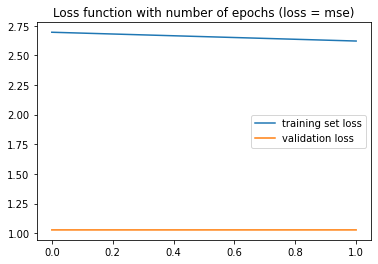

In [135]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])

plt.legend(['training set loss','validation loss'])

plt.title('Loss function with number of epochs (loss = mse)')

plt.show()

In [136]:
NN_pred = model.predict_classes(X_test)+1

In [137]:
NN_pred

array([1, 2, 3, ..., 1, 1, 1])

#### 5) Results

##### Model Performance

Normalized confusion matrix
[[0.75 0.19 0.05]
 [0.48 0.35 0.17]
 [0.3  0.4  0.3 ]]


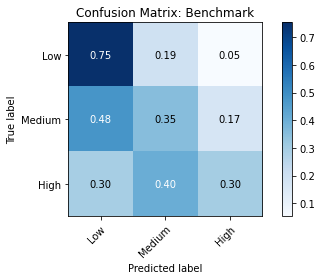

In [37]:
# Confusion matrix for 
plot_confusion_matrix(y_test, bl_test, classes=class_names, normalize=True, title='Confusion Matrix, Benchmark')

Normalized confusion matrix
[[0.9  0.09 0.01]
 [0.62 0.33 0.06]
 [0.33 0.5  0.18]]


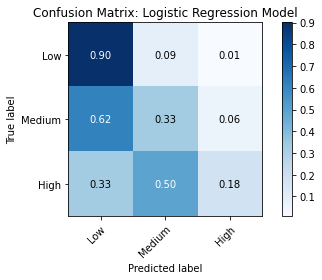

In [36]:
# Confusion matrix for 
plot_confusion_matrix(y_test, LR_pred, classes=class_names, normalize=True, title='Confusion Matrix, Logistic Regression Model')

Normalized confusion matrix
[[0.33 0.62 0.05]
 [0.05 0.72 0.23]
 [0.01 0.49 0.5 ]]


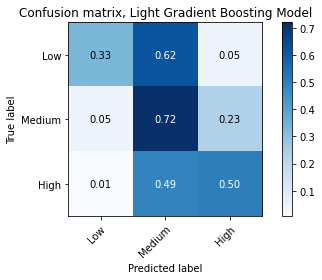

In [39]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, lgbm_pred.reshape(-1,1)+1, classes=class_names, normalize=True, title='Confusion matrix, Light Gradient Boosting Model')

Normalized confusion matrix
[[0.6  0.36 0.04]
 [0.19 0.59 0.22]
 [0.05 0.48 0.47]]


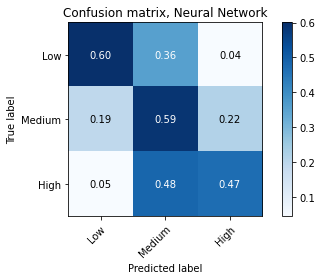

In [138]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test.values, NN_pred, classes=class_names, normalize=True, title='Confusion matrix, Neural Network')

In [40]:
print('\nClassification Report, Benchmark\n')
print(classification_report(y_test, bl_test))


Classification Report, Benchmark

              precision    recall  f1-score   support

           1       0.76      0.75      0.76     46394
           2       0.35      0.35      0.35     18396
           3       0.30      0.30      0.30      7678

    accuracy                           0.60     72468
   macro avg       0.47      0.47      0.47     72468
weighted avg       0.61      0.60      0.60     72468



In [41]:
print('\nClassification Report, Logistic Regression Model\n')
print(classification_report(y_test, LR_pred))


Classification Report, Logistic Regression Model

              precision    recall  f1-score   support

           1       0.75      0.90      0.82     46394
           2       0.43      0.33      0.37     18396
           3       0.49      0.18      0.26      7678

    accuracy                           0.68     72468
   macro avg       0.56      0.47      0.48     72468
weighted avg       0.64      0.68      0.65     72468



In [43]:
print('\nClassification Report, Light Gradient Boosting Model\n')
print(classification_report(y_test, lgbm_pred+1))


Classification Report, Light Gradient Boosting Model

              precision    recall  f1-score   support

           1       0.95      0.33      0.49     46394
           2       0.29      0.72      0.41     18396
           3       0.37      0.50      0.43      7678

    accuracy                           0.45     72468
   macro avg       0.54      0.52      0.45     72468
weighted avg       0.72      0.45      0.47     72468



Text(0.5, 1.0, 'Feature Importance; GBM')

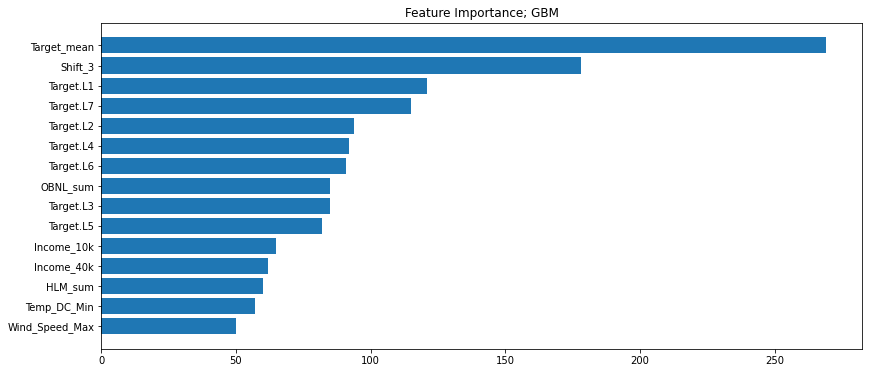

In [33]:
# Pour le GBM
feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
sorted_idx_ = sorted_idx[-15:]
pos = np.arange(sorted_idx_.shape[0]) + .5
fig = plt.figure(figsize=(30, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx_], align='center')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx_])
plt.title('Feature Importance; GBM')

#### 6) Save results

In [139]:
preds = pd.DataFrame(lgbm_pred+1, columns=['Prediction'])

In [182]:
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [183]:
to_out = preds.join(master_final['2019-06-01':'2020-05-31'][['Station','Shift','Target']].reset_index())
to_out['Target'] = to_out['Target'].apply(lambda x: 'Low' if x == 1 else 'Medium' if x == 2  else 'High')
to_out['Prediction'] = to_out['Prediction'].apply(lambda x: 'Low' if x == 1 else 'Medium' if x == 2  else 'High')
to_out['Shift_Char'] = to_out['Shift'].apply(lambda x: 'Night' if x == 1 else 'Day' if x == 2  else 'Evening')
to_out = to_out[['Shift','Shift_Char','Station','DateFMT','Prediction']]
to_out = to_out[to_out['DateFMT']>='2020-05-01']
to_out.head()
to_out.to_csv('/content/drive/My Drive/Data/YCBS-299/Predictions.csv', index=False)